Ce notebook contient les jeux de données sur lesquelles la méthode Mc2PCA a été testée dans ce projet, et leurs descriptions. Il comprend la lecture des données et leur traitement jusqu'à une liste de tableaux numpy, prête à être passée à la fonction de la méthode. Il comprend également quelques plots et des tableaux de données pour mieux visualiser les séries temporelles étudiées.

Enfin il contient les résultats obtenu pour chaque jeu de données: le meilleur paramètre $p$ trouvé et la précision qui lui est associée, ainsi que le code qui a permit d'obtenir ces résultats.

Il y a 5 jeux de données en tout: 4 choisis sur le site UCI, et un déjà utilisé dans l'article.

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler

In [112]:
class MTS:   
    def __init__(self, ts):
             self.ts = ts
            
    def cov_mat(self, centering = True):
        stdsc = StandardScaler()
        X = self.ts
        X = stdsc.fit_transform(X)
        self.ts = X
        return X.transpose() @ X
    
    
class CPCA:
    def __init__(self, epsilon = 1e-5):
        self.cov = None
        self.epsilon = epsilon
        self.U = None
        self.V = None
        self.S = None
    
    def fit(self,listMTS):
        if (len(listMTS) > 0):
            P = listMTS[0].cov_mat().shape[1]
            cov_mat = [mat.cov_mat() for mat in listMTS]
            self.cov = sum(cov_mat)/len(cov_mat)
            #Add epsilon Id in order to ensure invertibility
            cov = self.cov + self.epsilon*np.eye(P)
            #Compute SVD
            U,S,V = np.linalg.svd(self.cov)
            #Save SVD
            self.U = U
            self.S = S
            self.V = V
        

    def pred(self, listMTS, ncp):
        predicted = []
        if (self.U is not None):
            predicted = [elem.ts @ self.U[:,:ncp] for elem in listMTS]
        return predicted
    
    def reconstitution_error(self, listMTS, ncp):
        mse = np.full(len(listMTS),np.inf)
        if (self.U is not None):
            prediction = self.pred(listMTS, ncp)
            reconstit = [elem @ ((self.U)[:,:ncp].transpose()) for elem in prediction]
            mse = [((listMTS[i].ts - reconstit[i])**2).sum() for i in range(len(prediction))]
        return mse
    
    
class Mc2PCA:
    def __init__(self,K, ncp, itermax = 1000, conv_crit = 1e-5):
        self.K = K
        self.N = None
        self.ncp = ncp
        self.iter_max = itermax
        self.converged = False
        self.CPCA_final = None
        self.conv_crit = conv_crit
        self.pred = None
        
    def fit(self, X):
        N = len(X)
        #initialisation
        index_cluster = np.tile(np.arange(self.K), int(N/self.K) + 1)[:N]
        to_continue = True
        i = 0
        old_error = -1
        
        while to_continue:

            #Split all MTS according to the cluster 
            #we store it in a list of lists of MTS (each list inside the list corresponding to a cluster)
            MTS_by_cluster = [[X[i] for i in list(np.where(index_cluster == j)[0])] for j in range(self.K)]

            CPCA_by_cluster = [CPCA() for i in range(self.K)]

            #fit by cluster
            [CPCA_by_cluster[i].fit(MTS_by_cluster[i]) for i in range(self.K)]

            res = np.array([cpca.reconstitution_error(X, self.ncp) for cpca in CPCA_by_cluster])
            #Update index cluster
            index_cluster = res.argmin(axis = 0)

            #new total error 
            new_error = res.min(axis = 0).sum()
            to_continue = (abs(old_error - new_error) > self.conv_crit) & (self.iter_max > i)
            self.converged = np.abs(old_error - new_error) < self.conv_crit

            #Updata
            old_error = new_error 
            i += 1
        self.CPCA_final = CPCA_by_cluster
        self.pred = index_cluster
        return index_cluster
    
    def precision(self,gt_cluster):
        index_cluster = self.pred
        N = gt_cluster.shape[0]
        g = np.unique(gt_cluster)
        nb_g = g.shape[0]

        G = [np.where(gt_cluster == i)[0] for i in range(nb_g)]
        C = [np.where(index_cluster == i)[0] for i in range(self.K)]
        
        #to handle case where a cluster is empty
        max_part = list()
        for j in range(self.K):
            l = list()
            for i in range(nb_g):
                if len(C[j])!=0:
                    l.append([np.intersect1d(G[i],C[j]).shape[0]/C[j].shape[0]])
                else:
                    l.append(0)
            max_part.append(np.max(l))
        max_part = np.array(max_part)
        
        #max_part = np.array([max([np.intersect1d(G[i],C[j]).shape[0]/C[j].shape[0] for i in range(nb_g)]) for j in range(self.K)])
        prop_part = np.array([C[j].shape[0]/N for j in range(self.K)])
        return max_part.dot(prop_part)
    
    
def search_ncp(X,K,ncp_list,y_true):
    pres = np.zeros(ncp_list.shape[0])
    for i in range(len(ncp_list)):
        m = Mc2PCA(K,ncp_list[i])
        m.fit(X)
        pres[i] = m.precision(y_true)
    pre = np.max(pres)
    best_ncp = ncp_list[np.argmax(pres)]
    return best_ncp, pre

# New datasets

## Mobile robot

The data is stored in three text files: one file for experiences in which the Pioneer was moving in a straight line, one in which it was turning in place, and one in which it was raising or lowering its gripper.

The description variable is a string of symbols. The string breaks down as follows:

"u" or "o" - unobstructed or obstructed\
"x.xs" - activity lasted x.x seconds\
activity - the activity and speed, if applicable, i.e. move100 = move forward at 100mm/sec\
visual - objects in the visual array are listed in sequence. "cAHEAD" indicates an object visible to channel c directly AHEAD of the Pioneer.\
\[visual.X\] - visual descriptions followed by a '.' and one character indicate that something special happens with the visible object. .V means the object Vanishes from sight during the activity. .D indicates that the object is Discovered (becomes visible) during the activity. .P indicates that the object is pushed.

An example: "u-3.5s-retr-100-aRIGHT.D" An unobstructed retreat (move) at -100 mm/sec for 3.5 seconds with an object being discovered in channel A. 

There are 102 move experiences, 42 turn experiences, 16 gripper experiences.

**Clustering task:** cluster the time series according to the 3 different experiences (move, gripper, turn).

In [113]:
path = 'datasets/pioneers/'

In [114]:
data_pd = pd.read_csv(path+'MOVE.DATA', sep=',', engine='python', header=None)
data_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,MOVE-TRIALT148,u-3.5s-retr-250-cAHEAD,1525.0,11.8,345.6,1276.0,1636.0,808.0,445.0,459.0,...,0.0,0.0,10000.0,140.0,0.0,0.0,0.0,10000.0,140.0,0.0
1,MOVE-TRIALT148,u-3.5s-retr-250-cAHEAD,1525.1,11.8,345.6,1276.0,1636.0,808.0,452.0,452.0,...,5.0,0.0,223.5,-102.0,188.0,0.0,0.0,10000.0,140.0,0.0
2,MOVE-TRIALT148,u-3.5s-retr-250-cAHEAD,1525.2,11.8,345.6,1276.0,1629.0,815.0,452.0,452.0,...,5.0,1.0,263.8,-86.0,169.0,0.0,0.0,10000.0,140.0,0.0
3,MOVE-TRIALT148,u-3.5s-retr-250-cAHEAD,1525.3,11.8,345.6,1276.0,1629.0,815.0,452.0,452.0,...,0.0,0.0,10000.0,140.0,0.0,0.0,0.0,10000.0,140.0,0.0
4,MOVE-TRIALT148,u-3.5s-retr-250-cAHEAD,1525.4,11.8,345.6,1276.0,1629.0,811.0,452.0,459.0,...,0.0,0.0,10000.0,140.0,0.0,0.0,0.0,10000.0,140.0,0.0


In [115]:
#séparation des données par séries temporelles

exp_names = np.unique(data_pd[0])

data_pioneers0 = list()
for i in range(exp_names.shape[0]):
    exp_n = data_pd[data_pd[0]==exp_names[i]]
    exp_n = exp_n.drop(columns=[0,1,2])
    data_pioneers0.append(exp_n.to_numpy())

#label 0: MOVE experience
labels_MOVE = np.zeros(len(data_pioneers0))

In [116]:
data_pd = pd.read_csv(path+'GRIPPER.DATA', sep=',', engine='python', header=None)
data_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,GRIPPER-TRIALT176,gripper-UP[DOWN]--cAHEAD,693.3,12.4,5.3,1466.0,5201.0,204.0,203.0,206.0,...,6.0,20.0,3621.9,13.0,23.0,5.0,4.0,418.8,-97.0,125.0
1,GRIPPER-TRIALT176,gripper-UP[DOWN]--cAHEAD,693.4,12.4,5.3,1466.0,5201.0,196.0,212.0,206.0,...,6.0,19.0,3535.7,13.0,24.0,5.0,5.0,421.4,-97.0,124.0
2,GRIPPER-TRIALT176,gripper-UP[DOWN]--cAHEAD,693.5,12.4,5.3,1466.0,5201.0,196.0,212.0,206.0,...,6.0,20.0,3452.9,13.0,24.0,6.0,3.0,421.4,-97.0,125.0
3,GRIPPER-TRIALT176,gripper-UP[DOWN]--cAHEAD,693.6,12.4,5.3,1466.0,5201.0,196.0,196.0,206.0,...,6.0,21.0,3373.1,12.0,24.0,5.0,4.0,418.8,-97.0,125.0
4,GRIPPER-TRIALT176,gripper-UP[DOWN]--cAHEAD,693.7,12.4,5.3,1466.0,5201.0,203.0,196.0,206.0,...,6.0,20.0,3452.9,13.0,24.0,5.0,4.0,418.8,-97.0,125.0


In [117]:
#séparation des données par séries temporelles

exp_names = np.unique(data_pd[0])

data_pioneers1 = list()
for i in range(exp_names.shape[0]):
    exp_n = data_pd[data_pd[0]==exp_names[i]]
    exp_n = exp_n.drop(columns=[0,1,2])
    data_pioneers1.append(exp_n.to_numpy())

#label 1: GRIPPER experience
labels_GRIP = np.ones(len(data_pioneers1))
labels = np.concatenate((labels_MOVE,labels_GRIP))
data_pioneers = data_pioneers0 + data_pioneers1

In [118]:
data_pd = pd.read_csv(path+'TURN.DATA', sep=',', engine='python', header=None)
data_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,TURN-TRIALT168,o-3.0s-turn100-cRIGHT,1620.9,11.8,234.1,1685.0,5201.0,5201.0,2104.0,5201.0,...,7.0,0.0,153.2,-10.0,238.0,8.0,2.0,1165.7,-70.0,66.0
1,TURN-TRIALT168,o-3.0s-turn100-cRIGHT,1621.0,11.8,234.1,1685.0,5201.0,5201.0,2104.0,5201.0,...,0.0,0.0,10000.0,140.0,0.0,11.0,8.0,1165.7,-74.0,63.0
2,TURN-TRIALT168,o-3.0s-turn100-cRIGHT,1621.1,11.8,234.1,1685.0,5201.0,5201.0,2104.0,5201.0,...,0.0,0.0,10000.0,140.0,0.0,14.0,7.0,1409.7,-63.0,56.0
3,TURN-TRIALT168,o-3.0s-turn100-cRIGHT,1621.2,11.8,234.1,1685.0,5201.0,5201.0,2104.0,5201.0,...,0.0,0.0,10000.0,140.0,0.0,15.0,7.0,1302.9,-62.0,59.0
4,TURN-TRIALT168,o-3.0s-turn100-cRIGHT,1621.3,11.8,234.1,1685.0,5201.0,5201.0,2104.0,5201.0,...,0.0,0.0,10000.0,140.0,0.0,22.0,6.0,1390.9,-66.0,57.0


**numpy data:** data_pioneers

**clusters:** labels

In [119]:
#séparation des données par séries temporelles

exp_names = np.unique(data_pd[0])

data_pioneers2 = list()
for i in range(exp_names.shape[0]):
    exp_n = data_pd[data_pd[0]==exp_names[i]]
    exp_n = exp_n.drop(columns=[0,1,2])
    data_pioneers2.append(exp_n.to_numpy())

#label 2: TURN experience
labels_TURN = np.ones(len(data_pioneers2))*2
#final list of labels
labels = np.concatenate((labels,labels_TURN))
#final list of data
data_pioneers = data_pioneers + data_pioneers2

#### Visualisation d'une série multivariée au hasard dans le jeu de données:

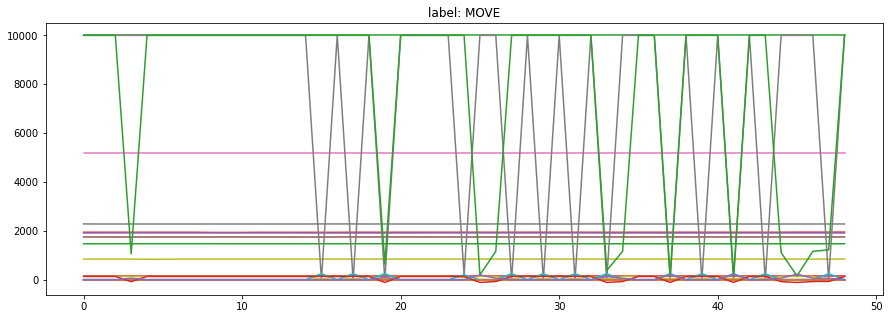

In [110]:
keys = ['MOVE','GRIPPER', 'TURN']
ax = plt.figure(figsize =(15,5))
i = np.random.randint(0,len(data_pioneers)-1)
plt.title('label: '+keys[int(labels[i])])
plt.plot(data_pioneers[i])
plt.show()

#### Visualisation des moyennes par classe:

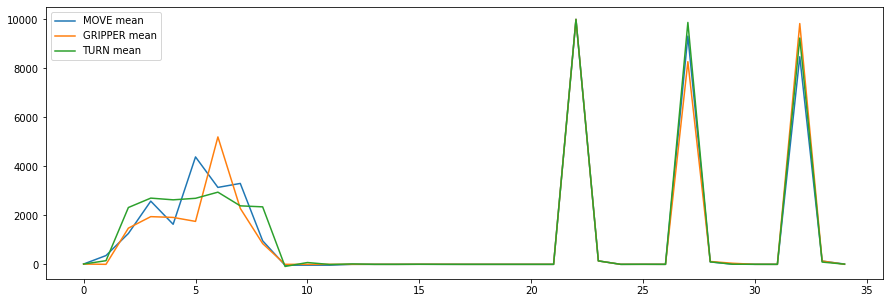

In [190]:
ax = plt.figure(figsize =(15,5))
plt.plot(np.mean(data_pioneers0[0], axis=0), label='MOVE mean')
plt.plot(np.mean(data_pioneers1[0], axis=0), label='GRIPPER mean')
plt.plot(np.mean(data_pioneers2[0], axis=0), label='TURN mean')
plt.legend()

### Result with the best ncp found

In [120]:
res = [MTS(elem) for elem in data_pioneers]
ncp_list = np.arange(1,int(data_pioneers[0].shape[1]*0.5))
search_ncp(res,3,ncp_list,labels)

(4, 0.79375)

**best ncp:** 4

**pre:** 0.7934

## Activity recognition


Dataset summary:\
#Activities: 33\
#Sensors: 9\
#Subjects: 17\
#Scenarios: 3 

The first to columns correspond to the timestamp while the last column corresponds to the
activity label.

ACTIVITY SET:\
A1: Walking\
A2: Jogging\
A3: Running\
A4: Jump up\
A5: Jump front & back\
A6: Jump sideways\
A7: Jump leg/arms open/closed\
A8: Jump rope\
A9: Trunk twist (arms outstretched)\
A10: Trunk twist (elbows bent)\
A11: Waist bends forward\
A12: Waist rotation\
A13: Waist bends (reach foot with opposite hand)\
A14: Reach heels backwards\
A15: Lateral bend (10_ to the left + 10_ to the right)\
A16: Lateral bend with arm up (10_ to the left + 10_ to the right)\
A17: Repetitive forward stretching\
A18: Upper trunk and lower body opposite twist\
A19: Lateral elevation of arms\
A20: Frontal elevation of arms\
A21: Frontal hand claps\
A22: Frontal crossing of arms\
A23: Shoulders high-amplitude rotation\
A24: Shoulders low-amplitude rotation\
A25: Arms inner rotation\
A26: Knees (alternating) to the breast\
A27: Heels (alternating) to the backside\
A28: Knees bending (crouching)\
A29: Knees (alternating) bending forward\
A30: Rotation on the knees\
A31: Rowing\
A32: Elliptical bike\
A33: Cycling 

The rows of the log file correspond to the consecutive samples of the mesurments sampled at 50 Hz. Each log file contains 120 columns.

The columns in between the 3rd and 119th column correspond to the sensor
measurements. There are 9 sensors in total with 13 modalities each.

**Clustering task:** cluster the data according to the different activities (33 clusters).

In [89]:
path = 'datasets/activity_recognition/realistic_sensor_displacement/'
files = os.listdir(path)

**numpy data:** data_activities

**clusters:** labels

In [90]:
#les fichiers étant très volumineux, on choisit de n'en prendre qu'une partie
files_subset = files[:3]

#regroupement et séparation des séries temporelles et création de la liste de labels
labels = list()
data_activity = list()
for f in files_subset:
    if '.log' in f:
        data_pd = pd.read_csv(path+f, sep='\t', engine='python', header=None)
        classes = data_pd[119]
        i=0
        while i < (len(classes)-1):
            start = i
            end = i
            d = list()
            labels.append(classes[i])
            while classes[i]==classes[i+1]:
                i += 1
                end = i
                if i==(len(classes)-1):
                    d.append(data_pd.iloc[start:end].drop(columns=[0,119]).to_numpy())
                    break
            d.append(data_pd.iloc[start:end].drop(columns=[0,119]).to_numpy())
            i +=1
            data_activity.append(d)


In [91]:
labels = np.array(labels)

data_activities = list()
for i in range(len(data_activity)):
    data_activities.append(data_activity[i][0])

#### Visualisation d'une série multivariée au hasard dans le jeu de données:

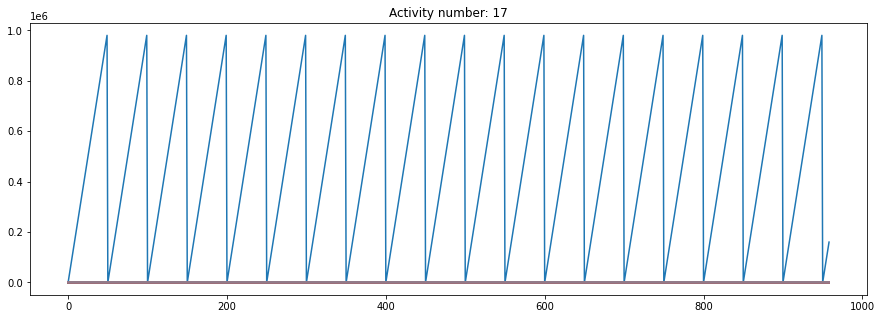

In [92]:
ax = plt.figure(figsize =(15,5))
i = np.random.randint(0,len(data_activities)-1)
plt.title('Activity number: '+str(labels[i]))
plt.plot(data_activities[i])
plt.show()

### Result with the best ncp found

In [29]:
res = [MTS(elem) for elem in data_activities]
ncp_list = np.arange(1,int(data_activities[0].shape[1]*0.5))
search_ncp(res,33,ncp_list,labels)

**best ncp:** 35

**pre:** 0.659

## Gas sensors

100 recordings of a sensor array under different conditions in a home setting: background, wine and banana presentations. The array includes 8 MOX gas sensors, and humidity and temperature sensors.

This dataset contains a set of time series from three different conditions: wine, banana and background activity. There are 36 inductions with wine, 33 with banana and 31 recordings of background activity. One possible application is to discriminate among background, wine and banana.

For each induction, we include one hour of background activity prior to and after the stimulus presentation. Time series were recorded at one sample per second, with minor variations at some data points due to issues in the wireless communication.

**Clustering task:** cluster the data according to the 3 different conditions (background, wine, banana).

In [121]:
path = 'datasets/wine_banana/HT_Sensor_UCIsubmission/'

In [122]:
metadata_pd = pd.read_csv(path+'HT_Sensor_metadata.dat', sep='\t', usecols=[0,2],
                          names=['id','class'], engine='python', skiprows=[0])
metadata_pd.head()

,id,class
0,0,banana
1,1,wine
2,2,wine
3,3,banana
4,4,wine


**numpy data:** data_gas

**clusters:** labels

In [123]:
#création de la liste de labels
name = metadata_pd['class']

name_unique = list(np.unique(name))
dict_name = dict(zip(name_unique, list(range(len(name_unique)))))

labels = np.array([dict_name.get(nom) for nom in name])

keys = list(dict_name.keys())

In [124]:
data_pd = pd.read_csv(path+'HT_Sensor_dataset.dat', sep='  ', engine='python', skiprows=[0], header=None)

data_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736


In [131]:
ids = metadata_pd['id']
data_gas = list()

#regroupement et séparation des séries temporelles
for i in range(ids.shape[0]):
    data_id = data_pd[data_pd[0]==ids[i]]
    data_id = data_id.drop(columns=[0])
    data_id = data_id[data_id[1] >= 0]
    if data_id.to_numpy().shape[0] != 0:
        data_gas.append(data_id.to_numpy())

#### Visualisation d'une série multivariée au hasard dans le jeu de données:

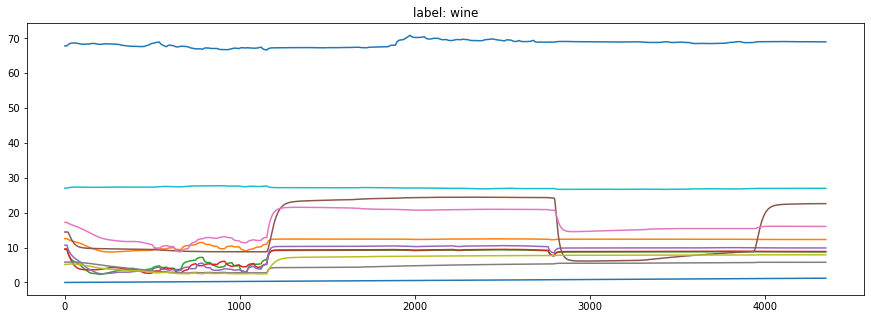

In [88]:
ax = plt.figure(figsize =(15,5))
i = np.random.randint(0,len(data_gas)-1)
plt.title('label: '+keys[labels[i]])
plt.plot(data_gas[i])
plt.show()

#### Visualisation des moyennes par classe:

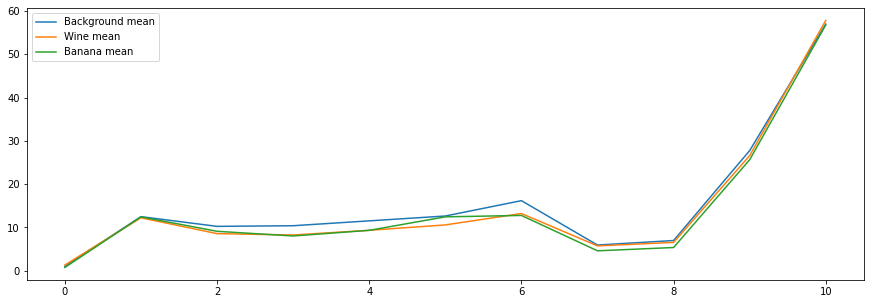

In [187]:
data_back = list()
for i in np.where(labels==0)[0]:
    data_back.append(data_gas[i])
mean_back = np.mean(data_back[0][:], axis=0)
    
data_wine = list()
for i in np.where(labels==1)[0]:
    data_wine.append(data_gas[i])
mean_wine = np.mean(data_wine[0][:], axis=0)
    
data_banana = list()
for i in np.where(labels==2)[0]:
    data_banana.append(data_gas[i])
mean_banana = np.mean(data_banana[0][:], axis=0)


ax = plt.figure(figsize =(15,5))
plt.plot(mean_back, label='Background mean')
plt.plot(mean_wine, label='Wine mean')
plt.plot(mean_banana, label='Banana mean')
plt.legend()

### Result with the best ncp found

In [132]:
res = [MTS(elem) for elem in data_gas]
ncp_list = np.arange(1,int(data_gas[0].shape[1]*0.5))
search_ncp(res,3,ncp_list,labels)

(1, 0.51)

**best ncp:** 1

**pre:** 0.51

En comparant les deux plots des deux datasets à trois clusters on peut avoir une intuition de pourquoi les performances de clustering sont meilleurs sur le dataset de Mobile Robot. En effet on peut voir que les troix moyennes correspondant aux trois clusters se distinguent bien moins facilement les unes des autres sur ce dataset des gas sensors.

## Sign language

Samples from a single signer (a native Auslan signer) were collected over a period of nine weeks. In total, 27 samples per sign, and a total of 2565 signs were collected. The average length of each sign was approximately 57 frames. 

The file consists of 9 subdirectories tctodd1-9. Each directory consists of 3 samples of each sign, captured on a different day. In total there are 95 different signs, with 27 samples per sign. Signs were provided by a native signer volunteer.

Each file consists of a sequence of lines. Each line consists of 22 whitespace-separated numbers representing the 22 channels of information. The list of channels can be found in the domain description file. It also lists the classes.

The following data were recorded for each hand:

x position expressed relative to a zero point set slightly below the chin. Expressed in meters.\
y position expressed relative to a zero point set slightly below the chin. Expressed in meters.\
z position expressed relative to a zero point set slightly below the chin. Expressed in meters.\
roll expressed as a value between -0.5 and 0.5 with 0 being palm down. Positive means the palm is rolled clockwise from the perspective of the signer. To get degrees, multiply by 180.\
pitch expressed as a value between -0.5 and 0.5 with 0 being palm flat (horizontal). Positive means the palm is pointing up. To get degrees, multiply by 180.\
yaw expressed a value between -1.0 and 1.0 with 0 being palm straight ahead from the perspective of the signer.\ Positive means clockwise from the perspective above the signer. To get degrees, multiply by 180.\
Thumb bend measure between 0 and 1. 0 means totally flat, 1 means totally bent. However, the finger bend measurements are not very exact.\
Forefinger bend measure between 0 and 1. 0 means totally flat, 1 means totally bent. However, the finger bend measurements are not very exact.\
Middle finger bend measure between 0 and 1. 0 means totally flat, 1 means totally bent. However, the finger bend measurements are not very exact.\
Ring finger bend measure between 0 and 1. 0 means totally flat, 1 means totally bent. However, the finger bend measurements are not very exact.\
Little finger bend measure between 0 and 1. 0 means totally flat, 1 means totally bent. However, the finger bend measurements are not very exact.


**Clustering task:** cluster the data according to the sign (95 clusters).


In [138]:
path = 'datasets/sign_language/tctodd/'

#list of lists, of all files per directory
directories = os.listdir(path)
directories = np.sort(directories)
files = list()
for direc in directories:
    f=os.listdir(path+direc)
    f = np.sort(f)
    f = [path+direc+'/'+name for name in f]
    files.append(f)

In [139]:
nb_signs = 95
sample_per_sign_per_file = 3
signs = list()

#create list of lists, of paths for sample per signs (95 signs, and 27 samples per sign)
for i in range(nb_signs):
    sample_per_sign = list()
    for l in range(len(files)):
        for j in range(sample_per_sign_per_file):
            sample_per_sign.append(files[l][i*3+j])
    signs.append(sample_per_sign)

In [158]:
signs[0] #one list in the list 'signs' corresponds to one sign

['datasets/sign_language/tctodd/tctodd1/God-1.tsd',
 'datasets/sign_language/tctodd/tctodd1/God-2.tsd',
 'datasets/sign_language/tctodd/tctodd1/God-3.tsd',
 'datasets/sign_language/tctodd/tctodd2/God-1.tsd',
 'datasets/sign_language/tctodd/tctodd2/God-2.tsd',
 'datasets/sign_language/tctodd/tctodd2/God-3.tsd',
 'datasets/sign_language/tctodd/tctodd3/God-1.tsd',
 'datasets/sign_language/tctodd/tctodd3/God-2.tsd',
 'datasets/sign_language/tctodd/tctodd3/God-3.tsd',
 'datasets/sign_language/tctodd/tctodd4/God-1.tsd',
 'datasets/sign_language/tctodd/tctodd4/God-2.tsd',
 'datasets/sign_language/tctodd/tctodd4/God-3.tsd',
 'datasets/sign_language/tctodd/tctodd5/God-1.tsd',
 'datasets/sign_language/tctodd/tctodd5/God-2.tsd',
 'datasets/sign_language/tctodd/tctodd5/God-3.tsd',
 'datasets/sign_language/tctodd/tctodd6/God-1.tsd',
 'datasets/sign_language/tctodd/tctodd6/God-2.tsd',
 'datasets/sign_language/tctodd/tctodd6/God-3.tsd',
 'datasets/sign_language/tctodd/tctodd7/God-1.tsd',
 'datasets/s

In [140]:
data_pd = pd.read_csv(signs[0][0], sep='\t', engine='python', header=None)
data_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.064909,0.034318,-0.043964,0.626383,0.499976,0.506653,0.648993,1.0,0.949510,0.965124,...,0.073279,-0.024444,0.233232,0.560134,0.606738,0.685484,0.758431,1.0,0.754117,1.0
1,-0.033878,0.034764,-0.032445,0.647282,0.486303,0.480203,0.915143,1.0,0.915993,1.000000,...,0.065376,-0.009397,0.194742,0.585891,0.632960,1.000000,0.916470,1.0,0.974510,1.0
2,0.015014,0.030924,-0.012665,0.646525,0.478735,0.466018,0.993164,1.0,0.911142,1.000000,...,0.040059,-0.006763,0.183840,0.576174,0.662819,1.000000,0.999608,1.0,1.000000,1.0
3,0.019613,0.030433,-0.000207,0.643083,0.484130,0.464675,1.000000,1.0,0.940249,1.000000,...,0.035996,-0.004575,0.192532,0.571828,0.666005,1.000000,1.000000,1.0,1.000000,1.0
4,0.019479,0.057759,0.007249,0.646513,0.512036,0.459853,1.000000,1.0,0.960536,1.000000,...,0.099354,-0.020828,0.204154,0.586355,0.656374,1.000000,0.961176,1.0,1.000000,1.0


**numpy data:** data_signs

**clusters:** labels

In [141]:
data_signs = list()

#création de la liste de données
for i in range(len(signs)):
    for j in range(27):
        sign = pd.read_csv(signs[i][j], sep='\t', engine='python', header=None)
        data_signs.append(sign.to_numpy())

In [142]:
signs_names = list()

for i in range(nb_signs):
    for k in range(27):
        signs_names.append(signs[i][0].split('/')[-1][:-6])

In [143]:
unique_names = np.unique(signs_names)

dict_name = dict(zip(unique_names, list(range(len(unique_names)))))

labels = np.array([dict_name.get(nom) for nom in signs_names])

keys = list(dict_name.keys())

#### Visualisation d'une série multivariée au hasard dans le jeu de données:

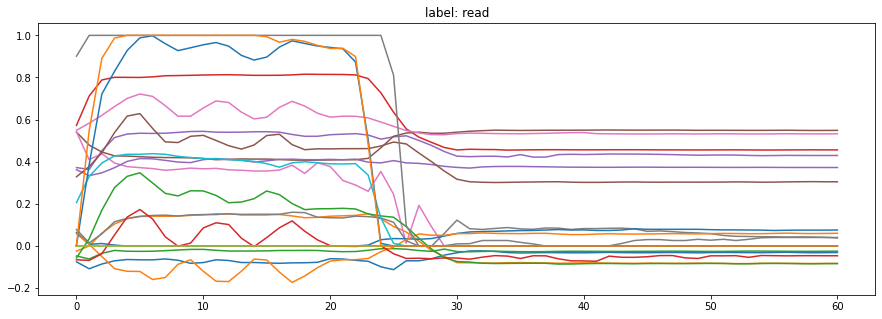

In [144]:
ax = plt.figure(figsize =(15,5))
i = np.random.randint(0,len(data_signs))
plt.title('label: '+keys[labels[i]])
plt.plot(data_signs[i])
plt.show()

### Result with the best ncp found

In [145]:
res = [MTS(elem) for elem in data_signs]
ncp_list = np.arange(1,int(data_signs[0].shape[1]*0.5))
search_ncp(res,95,ncp_list,labels)

(4, 0.4732943469785575)

**best ncp:** 4

**pre:** 0.473

# Dataset from paper

## Japanese vowels

This dataset records 640 time series of 12 LPC cepstrum coefficients taken from nine male speakers.
 
Nine male speakers uttered two Japanese vowels /ae/ successively. For each utterance, we applied 12-degree linear prediction analysis to it to obtain a discrete-time series with 12 LPC cepstrum coefficients. This means that one utterance by a speaker forms a time series whose length is in the range 7-29 and each point of a time series is of 12 features.


Sampling rate : 10kHz\
Frame length : 25.6 ms\
Shift length : 6.4ms\
Degree of LPC coefficients : 12 

Each speaker recorded several times the vowels, in different opportunities. There are between 24 and 88 records per speaker.

**Clustering task:** cluster the records according to the 9 speakers.

In [133]:
path = 'datasets/japanese_vowel/'

In [134]:
f = open(path+'ae.train','r')
lines_train = f.readlines()
f.close()
lines_train = [l.strip(' \n').split(' ') for l in lines_train]

f = open(path+'ae.test','r')
lines_test = f.readlines()
f.close()
lines_test = [l.strip(' \n').split(' ') for l in lines_test]

lines = lines_train + lines_test

In [135]:
#storing the number of blocks per speaker in the list "count"
f = open(path+'size_ae.train', 'r')
count_train = f.readlines()
count_train = [int(c) for c in count_train[0].strip(' \n').split(' ')]
f.close()
labels = list()

for i in range(len(count_train)):
    labels += [i] * count_train[i]
    
f = open(path+'size_ae.test', 'r')
count_test = f.readlines()
count_test = [int(c) for c in count_test[0].strip(' \n').split(' ')]
f.close()

for i in range(len(count_test)):
    labels += [i] * count_test[i]
    
labels = np.array(labels)

In [136]:
data_vowels = list()

s = 0
data = list()
for i in range(len(lines)):
    if lines[i]==['']:
        data = np.array(data)
        data_vowels.append(data)
        data = list()
        continue
    data.append(np.array([float(l) for l in lines[i]]))   

#### Visualisation d'une série multivariée au hasard dans le jeu de données:

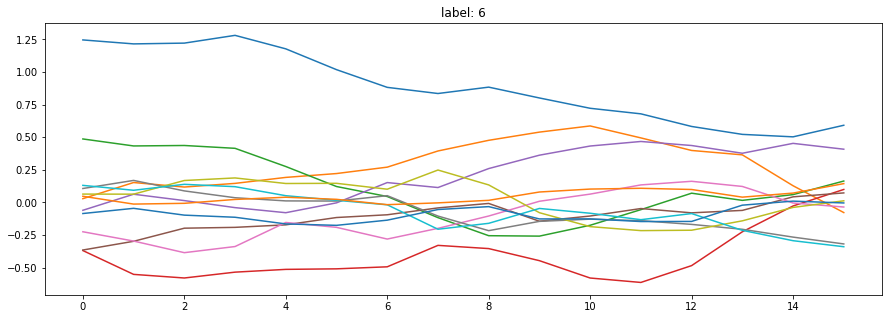

In [81]:
ax = plt.figure(figsize =(15,5))
i = np.random.randint(0,len(data_vowels))
plt.title('label: '+str(labels[i]))
plt.plot(data_vowels[i])
plt.show()

### Result with the best ncp found

In [137]:
res = [MTS(elem) for elem in data_vowels]
ncp_list = np.arange(1,int(data_vowels[0].shape[1]*0.5))
search_ncp(res,9,ncp_list,labels)

(3, 0.5890625)

**best ncp:** 3

**pre:** 0.589